In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

from datetime import datetime
def time_string():
    # return datetime.now().strftime("%d %B %Y %X")
    return datetime.now().strftime("%X")
impath = 'trash_img'    # путь к папке, в которой будут сохраняться картинки
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.size": 14,
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}'
})
plt.rcParams.update({
    "figure.figsize": (8, 6),
    'figure.dpi': 200,
    "axes.titlesize": 18,
})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(domain, 1), *(np.expand_dims(popt, 1)+deviations))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

def plot_approx(x, y, f, par_names_str, fun_name, yerr=None, visApproxError=True, p0=None):
    if yerr is not None:
        popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True, p0=p0)
    else:
        popt, pcov = curve_fit(f, x, y, p0=p0)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        print(v,'+-',er)
    approx_label = f"approximation by {fun_name}"
    if (err == np.inf).any():
        print('Аппроксимация не сошлась. Попробуй задать начальные параметры p0')
    else:
        par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
        for i in range(len(par_names)):
            t = par_names[i]
            if len(t) == 2:
                name, units = t
            else:
                name, units = *t, ''
            approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    teorPoints = 50
    indent = 0.05   # отступ по бокам от области экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*indent, b+(b-a)*indent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError and (pcov != np.inf).all():
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

def make_beautiful_plot(xname, xunit, yname, yunit, tight=True):
    plt.minorticks_on()
    plt.grid(True, which='minor', linewidth=0.2)
    plt.grid(True, which='major')
    plt.autoscale(tight=tight)
    plt.locator_params(axis='x', nbins=7, tight=True)
    plt.locator_params(axis='y', nbins=7, tight=True)
    plt.xlabel(fr"{xname}{" (" + xunit + ")" if xunit else ""}")
    plt.ylabel(fr"{yname}{" (" + yunit + ")" if yunit else ""}")
    plt.title(fr"{yname}({xname})")
    plt.legend()

In [65]:
#ВВод данных
# df = pd.read_excel("measurements.ods", engine="odf", sheet_name=0) # для таблиц ods (требуется установка pip install odfpy)
# df = pd.read_excel("measurements.xls")    # excel таблицы (требуется установка pip install xlrd)
# df = pd.read_excel("measurements.xlsx")    # excel таблицы (требуется установка pip install openpyxl)
df = pd.read_csv("DL project benchmarks - Sheet1.csv", skiprows=2)
x = df.iloc[:, 2].dropna()
y = df.iloc[:, 3].dropna()
df.head()

,Seq_len,forward time (s),Seq_len.1,backward time(s),Unnamed: 4,Seq_len.2,forward time (s).1,Seq_len.3,backward time(s).1,Unnamed: 9,...,backward time(s).2,Unnamed: 15,Seq_len.5,backward time(s).3,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,2.0,0.871729,2.0,1.781960,NaN,2.0,0.130291,2,1.083951,2.0,...,2.155090,NaN,2,9.593365,16.13107,NaN,7.75566,8.664139,NaN,5.822589
1,3.0,0.874027,3.0,2.656562,NaN,3.0,0.232391,3,2.257820,3.0,...,8.051072,NaN,3,12.583305,20.89988,NaN,14.37384,7.943882,NaN,7.115620
2,4.0,1.066333,4.0,4.432189,NaN,4.0,0.372964,4,1.624838,4.0,...,38.001972,NaN,4,13.113237,18.59271,NaN,15.84786,8.896214,NaN,9.116164
3,5.0,1.903685,5.0,11.626309,NaN,5.0,0.760390,5,1.644259,5.0,...,184.743205,NaN,5,16.820141,25.05398,NaN,17.74948,11.219450,NaN,13.257655
4,6.0,1.341091,6.0,15.225644,NaN,6.0,1.144503,6,2.141699,6.0,...,991.012180,NaN,6,18.382782,25.52685,NaN,20.09401,14.152456,NaN,13.757814


In [66]:
# параметры построения графика и аппроксимации прямой
# пользовательские параметры. Переменные x, y, xerr, yerr должны содержать данные
''' также необходимо изменить
название графика,
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
xname, xunit = r"sequence length", ""
yname, yunit = r"backward call time", "ms"
par_names_str = fr'''
k,
'''
# function to approximate
fun_name = r"$f(n) = k^n$"
def f(n, k, k_0):
    return k_0*k**n

par_names_str2 = fr'''
'''
fun_name2 =r"$f(n) = kn$"
def f2(x, k):
    return k * x
# конец пользовательских параметров

1.801970755975551 +- 0.09281132910879566
0.49409841498322304 +- 0.1681286640314808
0.3219651710529986 +- 0.009016407837308373


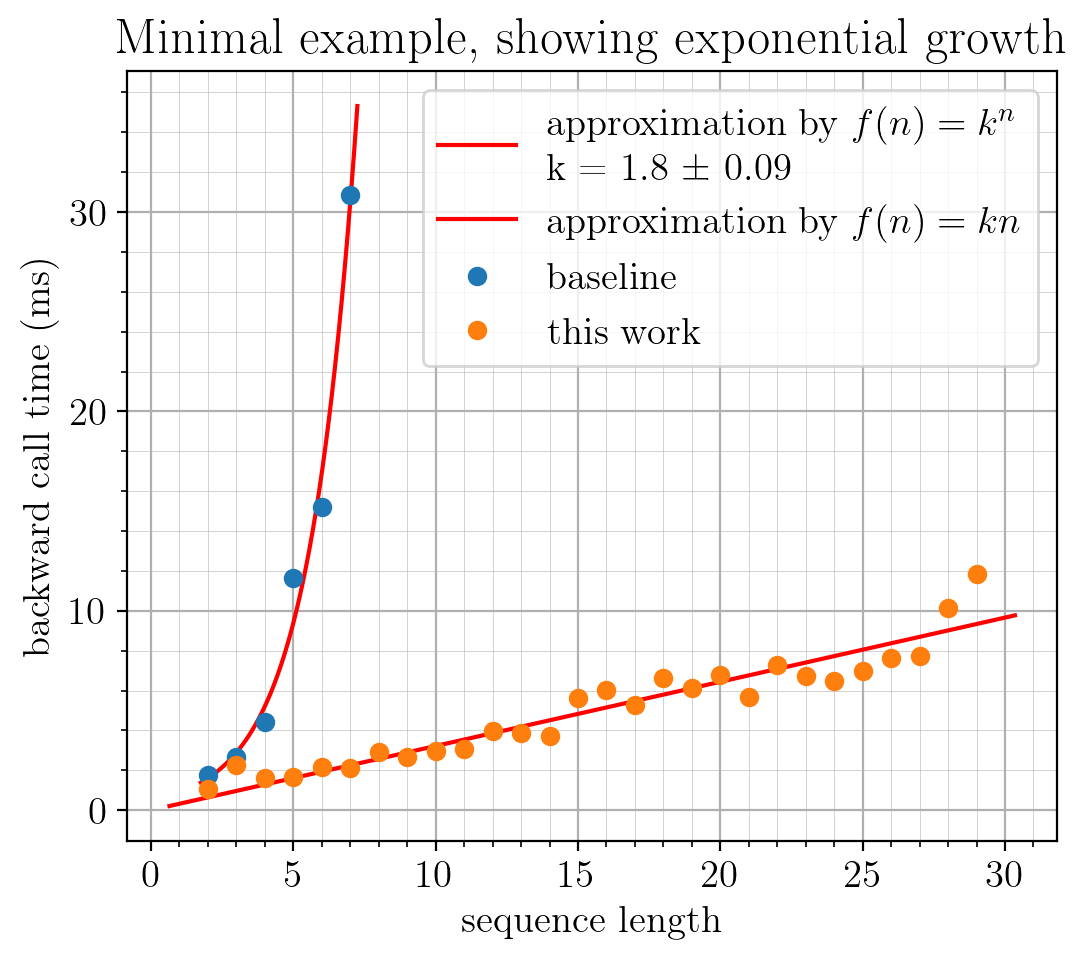

In [67]:
# построение графика

# аппроксимация
plt.figure(figsize=(6, 5))
# экспериментальные точки
x = df.iloc[:, 2].dropna()
y = df.iloc[:, 3].dropna()
plt.errorbar(x, y, fmt="o", label="baseline", capsize=4, ms=6)
plot_approx(x, y, f, par_names_str, fun_name, visApproxError=False)


x = df.iloc[:, 2+5].dropna()
y = df.iloc[:, 3+5].dropna()
plt.errorbar(x, y, fmt="o", label="this work", capsize=4, ms=6)
plot_approx(x, y, f2, par_names_str2, fun_name2, visApproxError=False)



make_beautiful_plot(xname, xunit, yname, yunit, tight=False)

plt.title("Minimal example, showing exponential growth")

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"{time_string()}.jpg"), dpi=300)

4.528718941676019 +- 0.07684381901272773
0.11312606098980088 +- 0.013345794436619048
9.008931485204515 +- 0.2649259023683402


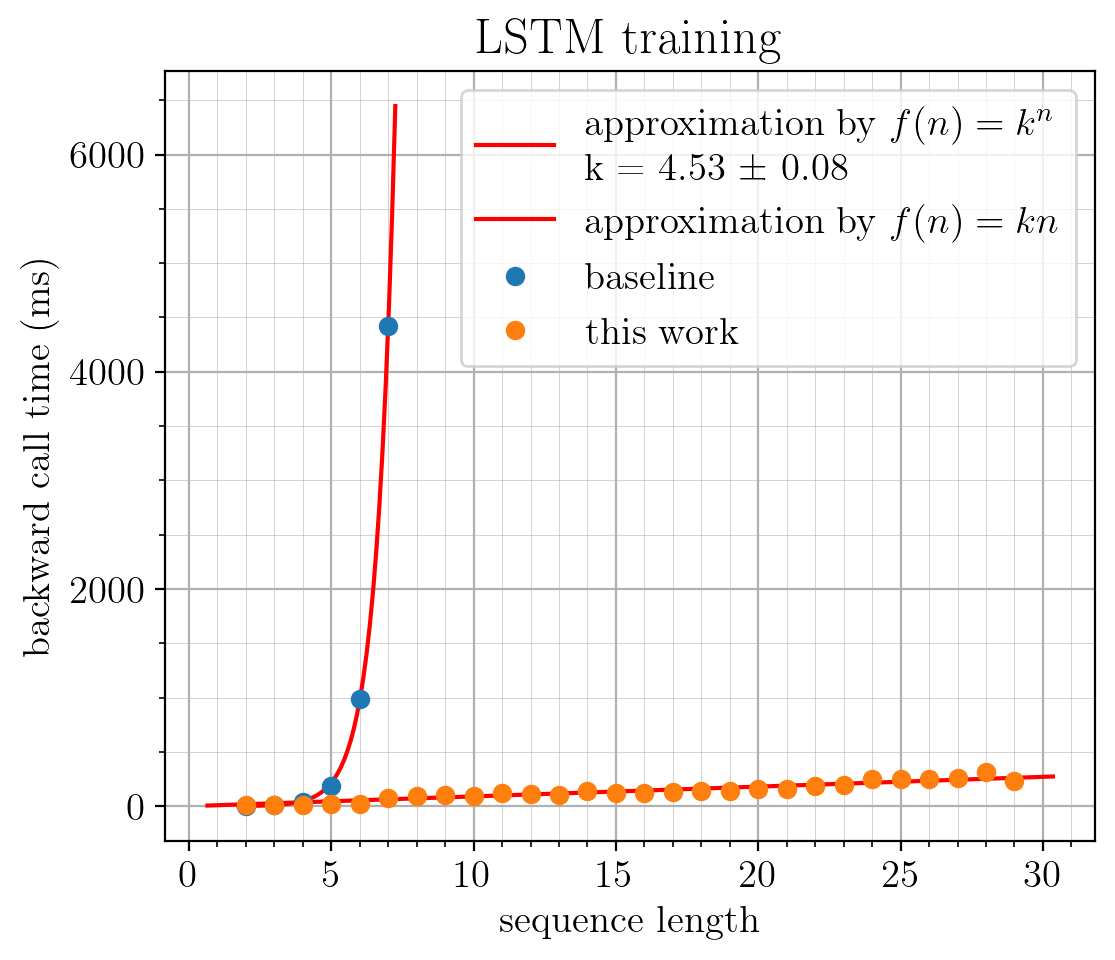

In [68]:
# построение графика

# аппроксимация
plt.figure(figsize=(6, 5))
# экспериментальные точки
x = df.iloc[:, 13].dropna()
y = df.iloc[:, 14].dropna()
plt.errorbar(x, y, fmt="o", label="baseline", capsize=4, ms=6)
plot_approx(x, y, f, par_names_str, fun_name, visApproxError=False)


x = df.iloc[:, 16].dropna()
y = df.iloc[:, 17].dropna()
plt.errorbar(x, y, fmt="o", label="this work", capsize=4, ms=6)
plot_approx(x, y, f2, par_names_str2, fun_name2, visApproxError=False)



make_beautiful_plot(xname, xunit, yname, yunit, tight=False)

plt.title("LSTM training")

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"{time_string()}.jpg"), dpi=300)